## Inference of Hodgkin-Huxley model on cell from Allen Cell Type Database

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments
from delfi.utils.viz import plot_pdf

%matplotlib inline

In [2]:
true_params, labels_params = utils.obs_params()

seed = None

obs = utils.allen_obs_data()
obs_stats = utils.allen_obs_stats()

I = obs['I']
dt = obs['dt']
t_on = obs['t_on']
t_off = obs['t_off']

m = HodgkinHuxley(I, dt, seed=seed, cython=True)
p = utils.prior(true_params=true_params, prior_extent=False, seed=seed)
s = HodgkinHuxleyStatsMoments(t_on=t_on, t_off=t_off)
g = dg.Default(model=m, prior=p, summary=s)

## CDELFI

In [ ]:
seed = 1
g = dg.Default(model=m, prior=p, summary=s)
res = infer.CDELFI(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True)

# run with N samples
out = res.run(1000, n_rounds=3)

In [4]:
posterior = res.predict(obs_stats)

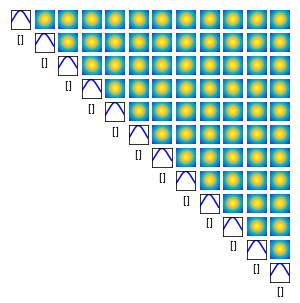

In [5]:
prior_min = res.generator.prior.lower
prior_max = res.generator.prior.upper

prior_lims = np.concatenate((prior_min.reshape(-1,1),
                             prior_max.reshape(-1,1)),
                            axis=1)

plot_pdf(posterior.xs[0], lims=prior_lims, samples=None);

## SNPE

In [3]:
seed = 1
g = dg.Default(model=m, prior=p, summary=s)
res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True,n_components=2)

# run with N samples
out = res.run(5000, n_rounds=5)

LinAlgError: Matrix is not positive definite

In [10]:
posterior = res.predict(obs_stats)

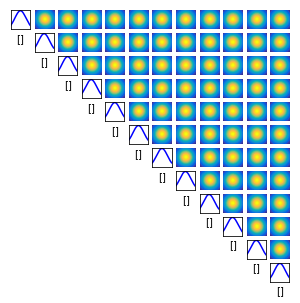

In [11]:
prior_min = res.generator.prior.lower
prior_max = res.generator.prior.upper

prior_lims = np.concatenate((prior_min.reshape(-1,1),
                             prior_max.reshape(-1,1)),
                            axis=1)

plot_pdf(posterior.xs[0], lims=prior_lims, samples=None);

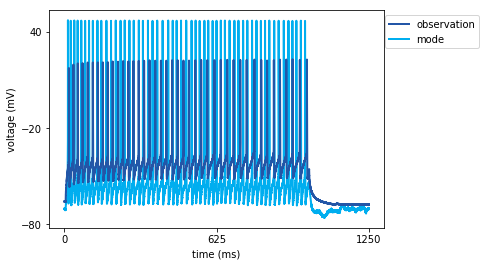

In [33]:
fig = plt.figure()

m, S = posterior.calc_mean_and_cov()
n_params = len(m)
y_obs = obs['data']
t = obs['time']
duration = np.max(t)

COL = {}
COL['GT']   = (35/255,86/255,167/255)
COL['SNPE'] = (0, 174/255,239/255)

num_samp = 0
num_colors = num_samp+1
cm1 = mpl.cm.Oranges
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

# sampling at contour of 1 covariance away from mean
x_samp = np.random.randn(n_params,num_samp)
x_samp = np.divide(x_samp,np.linalg.norm(x_samp,axis=0))
x_samp = (np.dot(S,x_samp)).T+m

params = np.concatenate((np.array([m]),x_samp))

V = np.zeros((len(t),1+num_samp))
for i in range(1+num_samp):
    m = HodgkinHuxley(I=I, dt=dt, seed=230+i)
    x = m.gen_single(params[i,:])
    V[:,i] = x['data']
#     V[:,i] = hh.sim_time(dt, t, I)[:,0]
    if i>0:
        plt.plot(t, V[:, i], color = col1[i-1], lw=2, label='sample '+str(num_samp-i+1))

# plotting simulation
plt.plot(t, V[:, 0], color=COL['SNPE'], lw=2, label='mode')
plt.plot(t, y_obs, color=COL['GT'], lw=2, label='observation')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40])